# Introduction
How to open and understand the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Basic information
1. Hyperspectral data:
    1. `hsi_path` contains path to hyperspectral masked numpy arrays containing hyperspectral data that underwent masking (i.e., the field area is masked, whereas all irrelevant areas are not masked)
    2. The name of the file (e.g., _'1989.npz'_) refers to the index of the corresponding training sample in the ground-truth table.
2. Ground-truth data:
    1. `gt_path` contains path to ground truth .csv file.
    2. Additionally, `wavelength_path` contains the mapping between a band number and the corresponding wavelength.


In [2]:
hsi_path = 'D:/datasets/soilHyperspec/train_data/train_data/train_data/1500.npz'
gt_path = 'D:/datasets/soilHyperspec/train_data/train_data/train_gt.csv'
wavelength_path = 'D:/datasets/soilHyperspec/train_data/train_data/wavelengths.csv'

In [3]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

## Ground-truth description
`gt_df` contains:

1. `sample_index` - a reference to the numpay array containing the corresponding hyperspectral data.
2. P (for simplicity, we use P while referring to P_2O_5), K, Mg, pH - soil properties levels based on laboratory measurements.

In [4]:
gt_df[gt_df['sample_index']==150]

,sample_index,P,K,Mg,pH
150,150,140.0,312.0,216.0,7.4


## Displaying one hyperspectral band

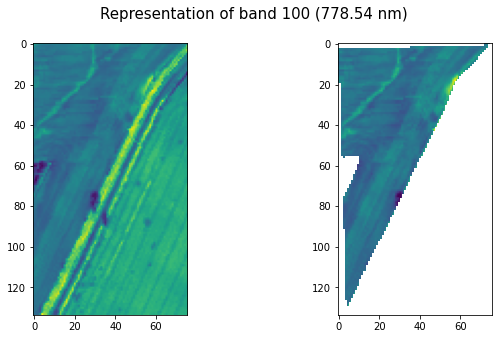

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])

plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

## Displaying the aggregated spectral curve for a field

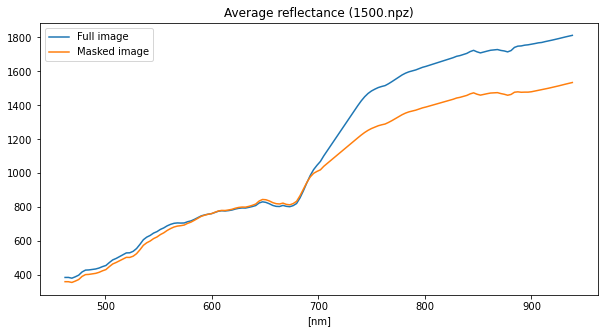

In [6]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.show()

# Shapes and DS size

In [7]:
import os
trainSize = len(os.listdir('D:/datasets/soilHyperspec/train_data/train_data/train_data'))
print('Amount training images:',trainSize)                           

Amount training images: 1733


In [8]:
hsi_path = 'D:/datasets/soilHyperspec/train_data/train_data/train_data/1500.npz'

sizes = []
for file in os.listdir('D:/datasets/soilHyperspec/train_data/train_data/train_data'):
    if file == '.DS_Store':
        continue
    with np.load('D:/datasets/soilHyperspec/train_data/train_data/train_data/' + file) as npz:
        arr = np.ma.MaskedArray(**npz)
        sizes.append(arr.shape[1:3])

In [33]:
import sys
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=False)
print(np.unique(sizes,axis=0))

[[ 11  11]
 [ 16  71]
 [ 17  93]
 ...
 [213 108]
 [217  68]
 [268  32]]


# Inspect bands - One unmasked Image

In [10]:
with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

print(arr.data.shape)

(150, 134, 76)


In [11]:
#may use for masked image
#cleanArr = np.delete(arr, np.where(arr == None))

In [12]:
newArr = arr.data.reshape(150, 10184)

In [13]:
print(newArr[0:10])
print(newArr.shape)

[[480 449 418 ... 386 365 398]
 [487 452 423 ... 382 372 398]
 [480 448 417 ... 377 369 392]
 ...
 [546 505 455 ... 422 404 439]
 [548 507 464 ... 419 405 441]
 [550 510 470 ... 417 409 445]]
(150, 10184)


In [14]:
#For masked image - cut out masked vals

In [15]:
#Get means, histogram of values, range
#Columns represent same pixel over different bands
#Rows represent different pixels over one band
#Should I normalise the pixel values?

In [16]:
import pandas as pd

#bands as list
bands = [i for i in range (1,151)]

def bandOverview(arr):
    #Mean of each column (same pixel)
    means = list(np.mean(arr, axis = 1))

    #maxs/mins
    ma = list(np.max(arr, axis = 1))

    mi = list(np.min(arr, axis = 1))

    #range of each column
    ranges = list(np.ptp(arr, axis=1))

    #standard deviation
    stds = list(np.std(arr, axis=1))
    #show first 10 and last 10 bands
    df = pd.DataFrame({"Band": bands[0:10]+['...']+bands[-10:],
                           "Mean": means[0:10]+['...']+means[-10:],
                           "Min": mi[0:10]+['...']+mi[-10:],
                           "Max": ma[0:10]+['...']+ma[-10:],
                           "Range": ranges[0:10]+['...']+ranges[-10:],
                           "std dev": stds[0:10]+['...']+stds[-10:]})
    print(df)
    return means, ma, mi, ranges, stds
    
means, ma, mi, ranges, stds = bandOverview(newArr)

   Band         Mean  Min   Max Range     std dev
0     1   387.068735   91  1066   975   93.564464
1     2   387.207286   90  1072   982   93.812512
2     3   382.787215   89  1060   971   93.443688
3     4   390.933032   95  1077   982   94.869252
4     5   400.475157  100  1095   995    96.50284
5     6   419.461312  111  1130  1019   99.378546
6     7   430.282502  118  1148  1030  101.178297
7     8   431.345051  116  1138  1022  101.512695
8     9   433.909957  117  1137  1020  102.151425
9    10   436.937844  117  1140  1023  102.696652
10  ...          ...  ...   ...   ...         ...
11  141  1769.805676  564  3236  2672  381.052156
12  142  1774.794482  569  3237  2668  381.686043
13  143  1778.909957  573  3237  2664  381.888808
14  144   1783.32718  578  3238  2660  382.204227
15  145  1787.840632  582  3239  2657  382.553926
16  146  1792.665161  587  3241  2654  382.958085
17  147  1797.763452  592  3243  2651  383.373706
18  148  1802.547624  596  3244  2648  383.789383


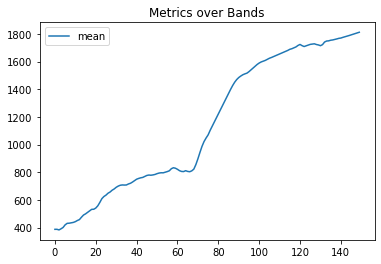

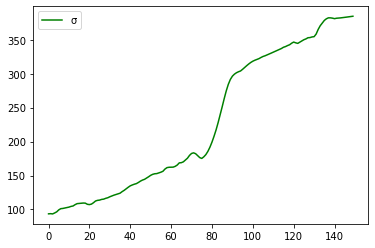

In [17]:
import matplotlib.pyplot as plt
def plotBands(means,stds):
    plt.figure()
    plt.title('Metrics over Bands')

    plt.plot(means)
    plt.legend(['mean'])
    plt.show()
    
    plt.figure()
    plt.plot(stds,color='green')
    plt.legend(['\u03C3'])

plotBands(means,stds)

# Inspect bands - All Images

In [18]:
test = 'D:/datasets/soilHyperspec/train_data/train_data/train_data/1500.npz'

#load in data, reshape and stack it 
for i in range (0,1732):
    path = r"D:/datasets/soilHyperspec/train_data/train_data/train_data/" + str(i) + ".npz"
    with np.load(path) as npz:
        arr = np.ma.MaskedArray(**npz)
    reshapeRatio = (arr.shape[1])*(arr.shape[2])
    newArr = arr.data.reshape(150, reshapeRatio)
    if i == 0:
        allIms = newArr
    else:
        np.hstack((allIms,newArr))

In [19]:
means, ma, mi, ranges, stds = bandOverview(allIms)

   Band         Mean   Min   Max Range    std dev
0     1   450.446281   409   505    96  19.673345
1     2   450.991736   409   508    99  19.822141
2     3   446.842975   403   501    98    19.8536
3     4   454.636364   407   510   103  20.534993
4     5   466.008264   418   525   107  21.318713
5     6   486.834711   433   548   115  22.167412
6     7   499.487603   441   563   122   22.91815
7     8    501.68595   443   565   122  22.806057
8     9   505.041322   452   569   117  22.593569
9    10   509.644628   460   573   113  22.805994
10  ...          ...   ...   ...   ...        ...
11  141  1508.545455  1352  1664   312  65.823706
12  142  1512.528926  1361  1669   308  65.677534
13  143  1516.239669  1366  1672   306  65.513865
14  144  1520.338843  1370  1675   305  65.461181
15  145   1524.46281  1375  1679   304  65.313743
16  146  1529.016529  1380  1683   303  65.209641
17  147   1533.85124  1386  1687   301  65.121331
18  148  1538.371901  1391  1691   300  65.078228


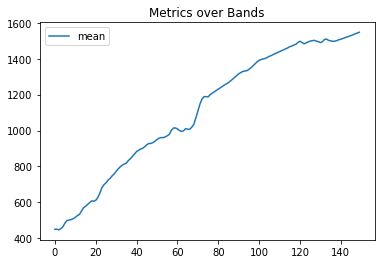

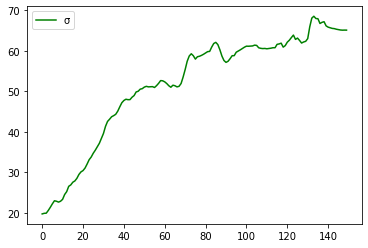

In [20]:
plotBands(means,stds)

In [21]:
#from sklearn.decomposition import PCA

In [22]:
#testing & debugging reshape
np.set_printoptions(threshold=sys.maxsize)
test1 = [[1,9,3],[1,8,3],[5,2,3]],[[1,2,2],[9,2,3],[1,2,4]]
test1 = np.array(test1)
print(test1.shape)
test2 = test1.reshape((2,9))
print(test2)

(2, 3, 3)
[[1 9 3 1 8 3 5 2 3]
 [1 2 2 9 2 3 1 2 4]]


# [Redacted] Dimensionality Reduction

https://www.spectralpython.net/algorithms.html#:~:text=To%20reduce%20dimensionality%20using%20principal%20components%2C%20we%20can,pixels%20by%20projecting%20them%20onto%20the%20remaining%20eigenvectors.


In [25]:
hsi_path = r'D:/datasets/soilHyperspec/train_data/train_data/train_data/1500.npz'




In [26]:
#load HS image
from spectral import *
with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

In [27]:
print(arr.shape)
#swap axis's for spectral library
arr2 = np.swapaxes(arr, 0, 2)
print(arr2.shape)

(150, 134, 76)
(76, 134, 150)



Many of the bands within hyperspectral images are often strongly correlated.
The principal components transformation represents a linear transformation of the original image bands to a
set of new, uncorrelated features. 
These new features correspond to the eigenvectors of the image covariance matrix, 
where the associated eigenvalue represents the variance in the direction of the eigenvector. 
A very large percentage of the image variance can be captured in a relatively small number of principal components 
(compared to the original number of bands) .

The SPy function principal_components computes the principal components of the image data 
and returns the mean, covariance, eigenvalues, and eigenvectors in a PrincipalComponents. 
This object also contains a transform to rotate data in to the space of the principal compenents, 
as well as a method to reduce the number of eigenvectors.


In [28]:
pc = principal_components(arr2)

(150, 150)


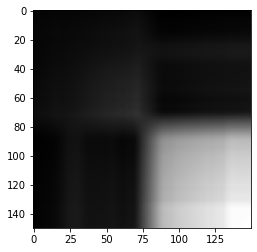

In [29]:
v = imshow(pc.cov)
print(pc.cov.shape)

In the covariance matrix display, whiter values indicate strong positive covariance, darker values indicate strong negative covariance, and grey values indicate covariance near zero.

To reduce dimensionality using principal components, we can sort the eigenvalues in descending order and then retain enough eigenvalues (an corresponding eigenvectors) to capture a desired fraction of the total image variance. We then reduce the dimensionality of the image pixels by projecting them onto the remaining eigenvectors. We will choose to retain a minimum of 99.9% of the total image variance.

8


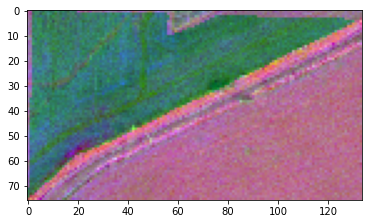

In [30]:
pc_0999 = pc.reduce(fraction=0.999)

# How many eigenvalues are left?

print(len(pc_0999.eigenvalues))


img_pc = pc_0999.transform(arr2)

v = imshow(img_pc[:,:,:150], stretch_all=True)

CoVariance over more samples

In [31]:
base_hsi_path = '../train_data/train_data/train_data/'
fType = '.npz'
samples = [0,320,640,960,1280,1600]